# An Exploration of Lethal Outcomes in Cases of Myocardial Infarction using Deep Learning

#### <center>Yi-Jin Chen, John Arnn, Luis Alegria</center>

### <center>Introduction</center>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Myocardial infarctions (MI), commonly referred to as heart attacks, occur after a blockage in the blood vessels supplying oxygen to heart muscles. This medical condition is considered life-threatening, and individuals not administered medical treatments promptly can have lethal outcomes. Certain risk factors and conditions predispose individuals to suffer heart attacks. These include hypertension, cigarette smoking, type II diabetes, and a sedentary lifestyle (1). In the United States, an estimated 805,000 individuals suffer a heart attack annually, and 1 in 5 may not perceive that they have suffered one (2). Given that heart attacks are prevalent and can lead to loss of life, it is essential to determine factors and medical treatments that can reduce the possibility of a lethal outcome. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Our group chose to analyze a data set collected by Golovenkin et al. to explore MI using deep learning methods (3). This set contains information for MI patients seen at Krasnoyarsk Interdistrict Clinical Hospital in Russia from 1992-1995. It consists of 111 features, excluding the ID column, and 12 outcomes. Of the 111 features, nine were collected at various time points after hospital admission. For the outcomes, 11 have binary classes while one, lethal outcome,  has eight classes. The main objective of the analysis will be to use the features at the time of admission to classify lethal outcome after transformation into a binary class. Other objectives include: explore the data set with visualizations, drop features with more than 50%, find features that are correlated, train fully-connected and convolutional neural networks and measure their performance, both in unoptimized and optimized states. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; A literature review reveals several investigations into the MI topic. Convolutional neural networks have been used to detect MI from electrocardiogram data (4). In another study focused on the same type of data, ensemble neural networks were employed to study the problem (5). Fully-connected architectures have also been used to investigate MI classification (6). 

####  <center> Imports </cemter>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow import keras

plt.style.use('seaborn-darkgrid')

### <center> Data Preparation </center>

To prepare the data set for analysis the following are performed:
- drop ID column
- drop features recorded after patient admission to hospital
- drop outcomes not related to mortality
- convert mortality outcome from multi-class to binary class.

In [2]:
# Read CSV file containing the data.
mi = pd.read_csv('./data_csv/Myocardial infarction complications Database.csv')

In [3]:
# In its raw state, the data set contains 1700 instances with 124 columns. 
mi.shape

(1700, 124)

In [4]:
# First few entries of the set# ID, features after admission, 
# and any outcome not lethal outcome needs to be removed

# features after admission : First three are for pain relapse, second three for use
# opioids in the ICU, last three for use of NSAIDs

# Outcomes to be dropped: Atrial fibrillation, Supraventricular tachycardia, 
# Ventricular tachycardia, Ventricular fibrillation, Third-degree AV block,
# Pulmonary edema, Myocardial rupture, Dressler syndrome, Chronic heart failure,
# Relapse of the myocardial infarction, Post-infarction angina

#list of column labels to be dropped
drop_columns = ['ID',
               'R_AB_1_n', 'R_AB_2_n', 'R_AB_3_n', 'NA_R_1_n', 'NA_R_2_n',
               'NA_R_3_n', 'NOT_NA_1_n', 'NOT_NA_2_n', 'NOT_NA_3_n',
               'FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
               'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN']

mi = mi.drop(columns = drop_columns)

# after the drops, there is 102 features and the outcome
mi.shape

(1700, 103)

In [5]:
# outcome has eight classes
mi['LET_IS'].value_counts()

0    1429
1     110
3      54
7      27
6      27
4      23
2      18
5      12
Name: LET_IS, dtype: int64

In [6]:
mi = mi.replace({'LET_IS': [i for i in range(1, 8)]}, 1)
mi['LET_IS'].value_counts()

0    1429
1     271
Name: LET_IS, dtype: int64

### <center> Descriptive Statistics and Missing Values </center>

In this section the aim is to explore the dataset using descriptive statistics and visualizations as well as investigate missing values in the data set.

In [7]:
# Separate the data into featurea and outcome or target
X = mi.drop(columns = ['LET_IS'])
y = mi['LET_IS']

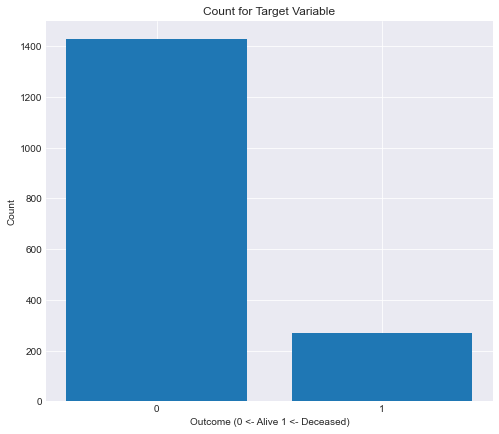

In [8]:
# bar plot to visualize counts of outcome values
# The plot shows that the data is unbalanced
fig, ax = plt.subplots(figsize = (8, 7))
ax.bar(x = [0, 1], height = y.value_counts())
ax.set_xticks([0, 1])
ax.set_xlabel('Outcome (0 <- Alive 1 <- Deceased)')
ax.set_ylabel('Count')
ax.set_title('Count for Target Variable')
plt.show()

In [9]:
# There are many features are not numeric, because they use number to classify. 
# They're actually categorical features.
# Binary data was treated as categorical data; ordinal data was treated as continuous variables (numerical) for simpler interpretation. 
# Reason from: https://www3.nd.edu/~rwilliam/stats3/OrdinalIndependent.pdf

# List to hold integer values of columns with numerical features
features = [0, *range(2,6), 7, 9, 10, *range(33,37), *range(43,47), 82, *range(84,91)]

# List to hold integer values of columns with categorical values
categories = [i for i in range(X.columns.size) if not (i in features)]

# locate all numerical features
numfeatures = X.iloc[:, features]

# locate all categorical features
catfeatures = X.iloc[:, categories]

# Print the total number in each category
print('The total number of numerical features:', len(numfeatures.columns))
print('The total number of categorical features:', len(catfeatures.columns))

The total number of numerical features: 24
The total number of categorical features: 78


In [10]:
# Describe method on the numerical features
numfeatures.describe()

,AGE,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,S_AD_KBRIG,D_AD_KBRIG,...,inf_im,post_im,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,KFK_BLOOD,L_BLOOD,ROE,TIME_B_S
count,1692.000000,1696.000000,1594.000000,1627.000000,1649.000000,1691.000000,1452.000000,1646.000000,624.000000,624.000000,...,1620.000000,1628.000000,1329.000000,1325.000000,1416.000000,1415.000000,4.000000,1575.000000,1497.000000,1574.000000
mean,61.856974,0.554835,2.316186,1.205286,1.160703,1.393258,3.340220,0.194411,136.907051,81.394231,...,1.014815,0.259214,4.191422,136.550943,0.481455,0.263717,2.000000,8.782914,13.444890,4.684244
std,11.259936,0.836801,2.440586,1.040814,0.801400,1.088803,3.098646,0.658722,34.997835,19.745045,...,1.404934,0.698850,0.754076,6.512120,0.387261,0.201802,1.095445,3.400557,11.296316,2.871044
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.300000,117.000000,0.030000,0.040000,1.200000,2.000000,1.000000,1.000000
25%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,70.000000,...,0.000000,0.000000,3.700000,133.000000,0.230000,0.150000,1.350000,6.400000,5.000000,2.000000
50%,63.000000,0.000000,1.000000,2.000000,1.000000,2.000000,3.000000,0.000000,140.000000,80.000000,...,0.000000,0.000000,4.100000,136.000000,0.380000,0.220000,1.600000,8.000000,10.000000,4.000000
75%,70.000000,1.000000,5.000000,2.000000,2.000000,2.000000,7.000000,0.000000,160.000000,90.000000,...,2.000000,0.000000,4.600000,140.000000,0.610000,0.330000,2.250000,10.450000,18.000000,7.000000
max,92.000000,3.000000,6.000000,4.000000,2.000000,3.000000,7.000000,4.000000,260.000000,190.000000,...,4.000000,4.000000,8.200000,169.000000,3.000000,2.150000,3.600000,27.900000,140.000000,9.000000


From the describe method, we see that for this data set the average age for the individuals is 61.9. This means that myocardial infarctions typically occur in older individuals.  

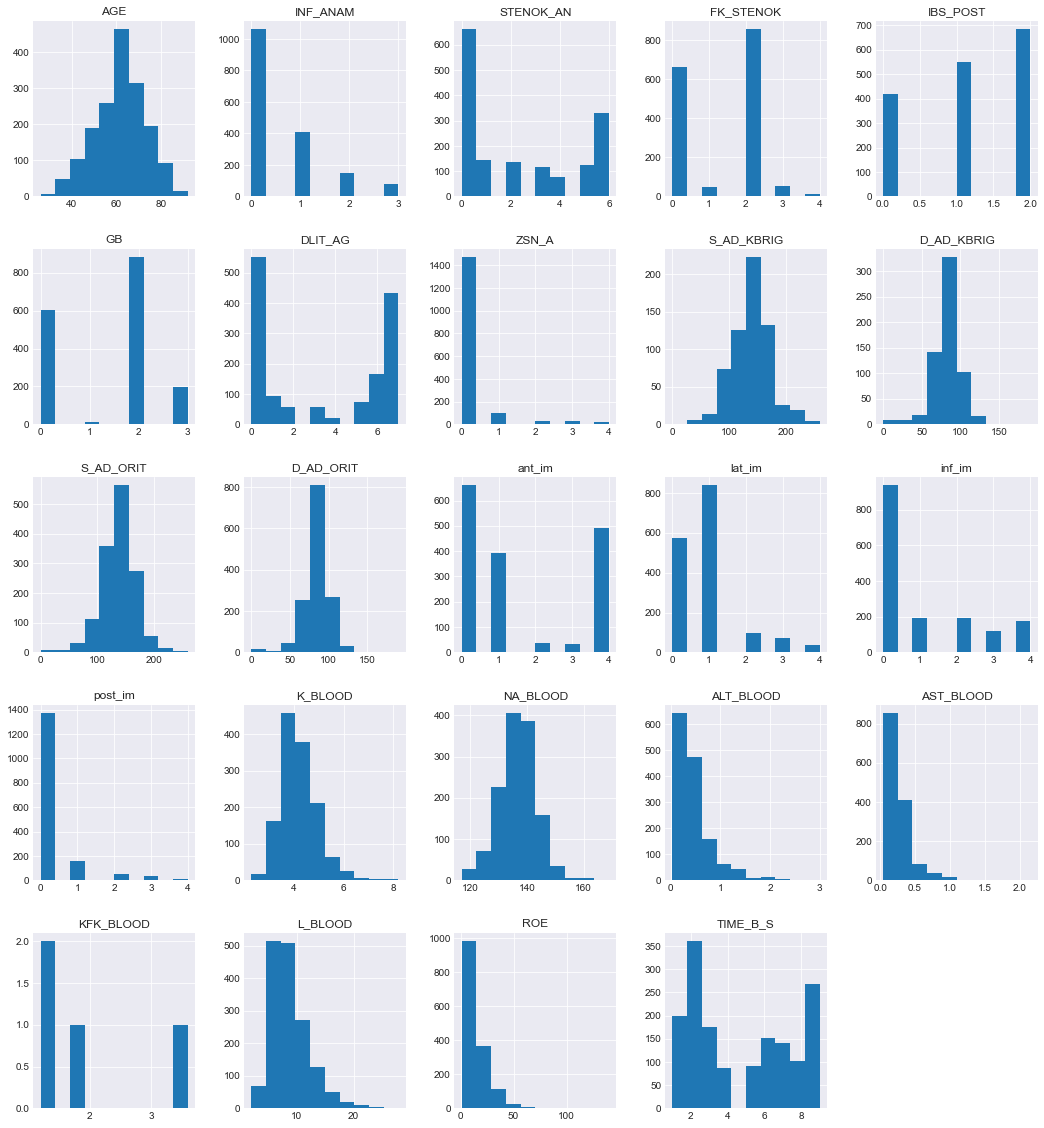

In [11]:
# Histogram for numerical features
X[numfeatures.columns].hist(figsize=(18,20))
plt.show()

*Discussion of Histograms of Numerical Features:* Some of the numerical features follow a normal distribution. These features are: age, lat_im, inf_im, post_im, K_Blood, L_Blood, ROE. Some are right-skewed. These include: Alt_blood, AST_blood. One appear to be bi-modal (TIME_B_S). 

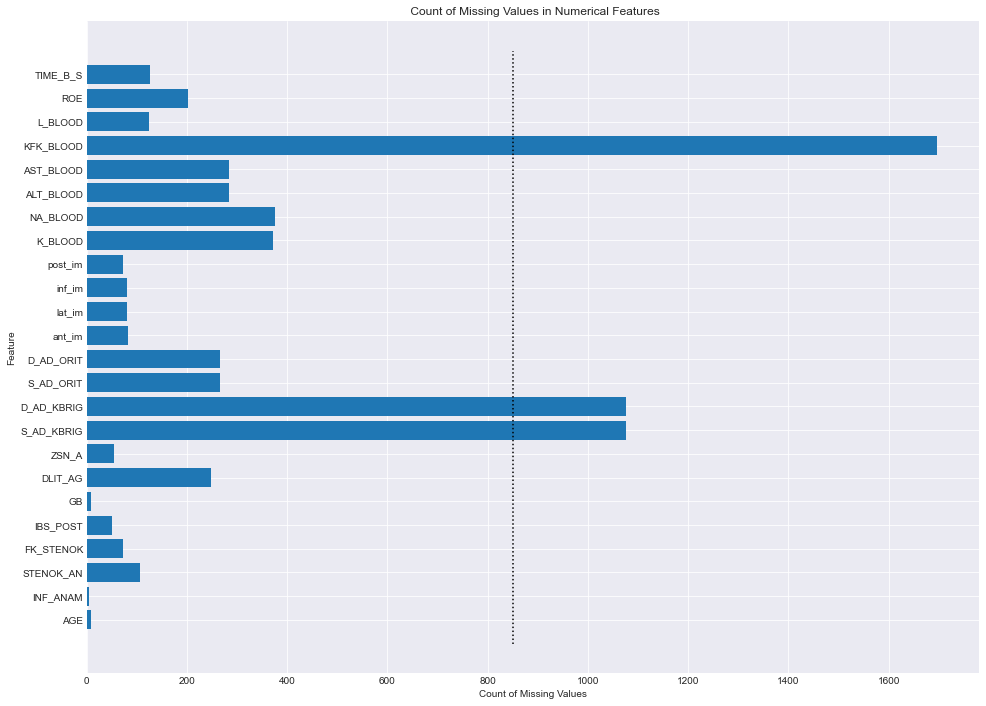

In [12]:
# Visualization of missing values in the dats set with a horizontal bar plot
# Any feature with > 50% missing values will be dropped. 

# Count of missing values.
na_count = X[numfeatures.columns].isnull().sum()
# list to hold values 0-23
marks = [i for i in range(0, len(na_count))]

fig, ax = plt.subplots(figsize = (16, 12))
ax.barh(y = marks, width = na_count.values)
ax.set_yticks(marks)
ax.set_yticklabels(na_count.index)
ax.set_xlabel('Count of Missing Values')
ax.set_ylabel('Feature')
ax.set_title(' Count of Missing Values in Numerical Features')
plt.vlines(x = 1700 / 2, ymin = -1 , ymax = 24, color = 'black',
          linestyles = 'dotted')
plt.show()

The features S_AD_KBRIG, D_AD_KBRIG, and KFK_BLOOD will be dropped since they have greater than 50% missing values.

In [13]:
newnumfeatures = numfeatures.loc[:, (numfeatures.isnull().sum(axis=0) < 1700/2)]

To explore if any of the numerical features are correlated a heat map is used. 

In [14]:
#Correlation for numerical features
cors = X[newnumfeatures.columns].corr()
# Mask with shape equivalent to numerical features
mask = np.zeros_like(cors)
#Perform mask
mask[np.triu_indices_from(mask, k=1)] = True

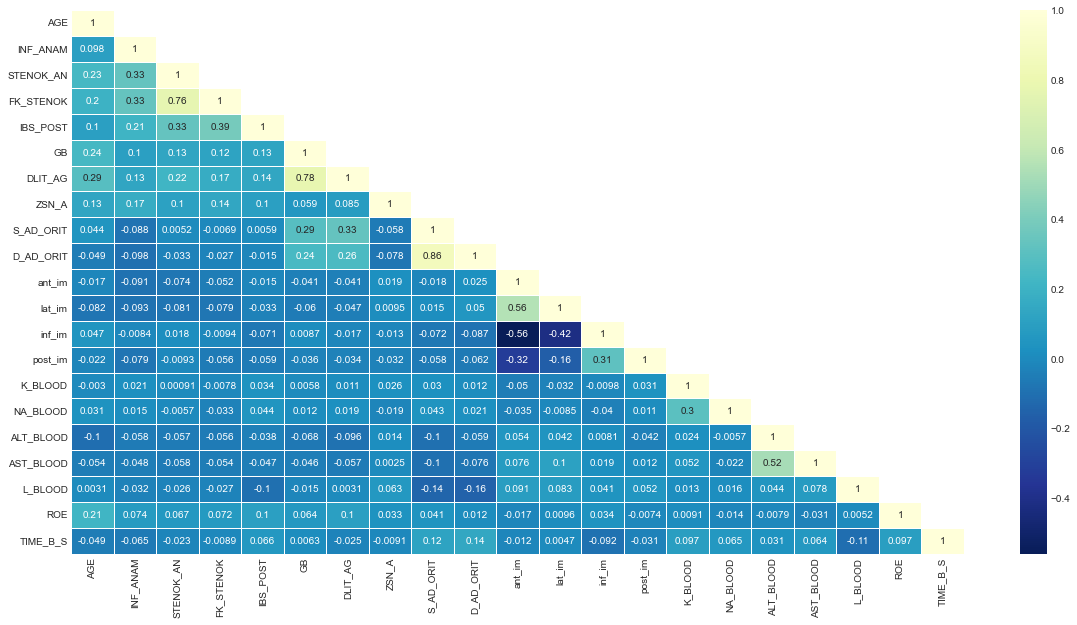

In [15]:
# Generate heatmap
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(20, 10))
    ax = sns.heatmap(cors, mask=mask, annot=True, linewidths=.5, cmap="YlGnBu_r")

Analysis of Heatmap: The most positively correlated features are D_AD_ORIT and S_AD_ORIT. The most negatively correlated are inf_im and ant_im.

To look at missing values for categorical features a horizontal bar plot will also be used. 

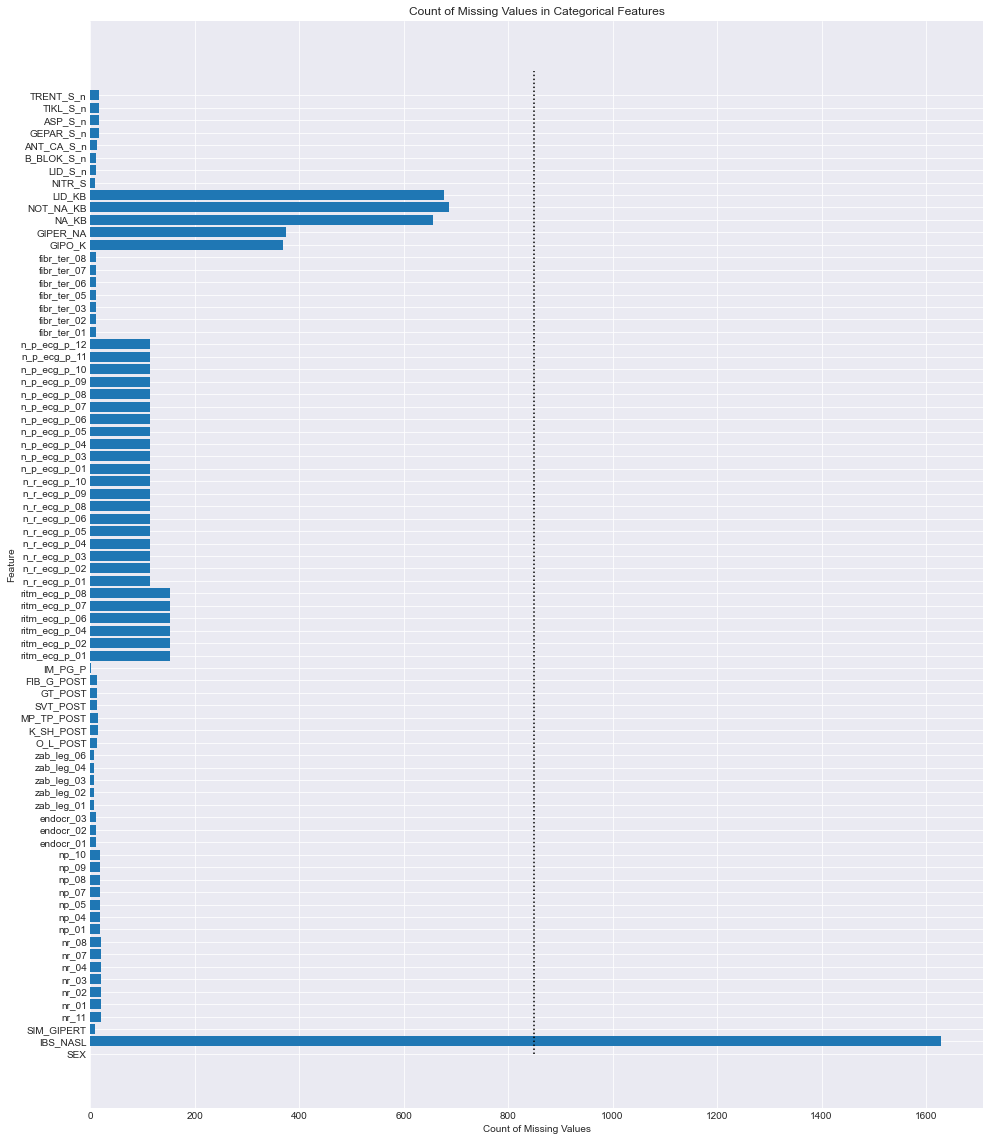

In [16]:
# Visualization of missing values in the dats set with a horizontal bar plot
# Any feature with > 50% missing values will be dropped. 

# Count of missing values.
na_count_cat = X[catfeatures.columns].isnull().sum()
# list to hold values 0-23
marks_cat = [i for i in range(0, len(na_count_cat))]

fig, ax = plt.subplots(figsize = (16, 20))
ax.barh(y = marks_cat, width = na_count_cat.values)
ax.set_yticks(marks_cat)
ax.set_yticklabels(na_count_cat.index)
ax.set_xlabel('Count of Missing Values')
ax.set_ylabel('Feature')
ax.set_title('Count of Missing Values in Categorical Features')
plt.vlines(x = 1700 / 2, ymin = 0 , ymax = 79, color = 'black',
          linestyles = 'dotted')
plt.show()

Since the feature IBS_NASL has >50% missing values, it will be dropped. 

In [17]:
newcatfeatures = catfeatures.loc[:, (catfeatures.isnull().sum(axis=0) < 1700/2)]

In [18]:
# Dropped the features from the analysis above
X = X.drop(columns = ['S_AD_KBRIG', 'D_AD_KBRIG', 'KFK_BLOOD','IBS_NASL'])
# Display shape before test-train split
X.shape

(1700, 98)

### <center> Test-Train Split </center>

The test train split will be stratified due to the imbalance of the outcome variable. In the following cell, the parameter stratify = y ensures that the same proportions of outcome variable is maintained in the splits. To ensure that we are all working with the same data, the splits will be converted to a pandas dataframe, exported to a csv file and place in out git repository. 

In [19]:
# From data exploration we found that the target varible is unbalanced so
# the data will be split in a stratified manner. 

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2,
#                                                    random_state = 42, stratify = y)

In [20]:
# concatanate training set
# df_train = pd.concat([X_train, y_train], axis = 1)

# concanate test set
# df_test = pd.concat([X_test, y_test], axis = 1)

In [21]:
# write data to csv
# df_train.to_csv('train')

# write data to csv
# df_test.to_csv('test')

### <center> Preparing Test-Train Split </center>

In [22]:
# Creation of imputer instances for categorical, numerical features, and MinMaxScaler
impute_num = SimpleImputer(missing_values = np.nan, strategy = 'mean')
impute_cat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
min_max_scaler = MinMaxScaler()

In [23]:
# In this cell we create two lists containing the name of numerical and categorical 
# features. Also dictionaries for later type casting are created. 

num = ['AGE', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB',
       'DLIT_AG', 'ZSN_A', 'S_AD_ORIT', 'D_AD_ORIT', 'ant_im', 'lat_im',
       'inf_im', 'post_im', 'K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD',
       'L_BLOOD', 'ROE', 'TIME_B_S']

num_type = ['float']

cat = ['SEX', 'SIM_GIPERT', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04',
       'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09',
       'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01',
       'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'O_L_POST',
       'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST',
       'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04',
       'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01',
       'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05',
       'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10',
       'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05',
       'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09',
       'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01',
       'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06',
       'fibr_ter_07', 'fibr_ter_08', 'GIPO_K', 'GIPER_NA', 'NA_KB',
       'NOT_NA_KB', 'LID_KB', 'NITR_S', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n',
       'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n', 'TRENT_S_n']

cat_type = ['Int64']
cat_type2 = ['int']

# dictionaries for type casting

num_dict = dict()
cat_dict = dict()
cat2_dict = dict()

for typ_n in num_type:
    for column in num:
        num_dict[column] = typ_n
        
for typ_c in cat_type:
    for column in cat:
        cat_dict[column] = typ_c
        
for typ_2c in cat_type2:
    for column in cat:
        cat2_dict[column] = typ_2c

# works for Python 3.9.0 or greater, merge two dictionaries
types = num_dict | cat_dict
types2 = num_dict | cat2_dict

# In Python 3.5 or greater
# types = {**num_dict, **cat_dict}

In [24]:
# read file with training data
train = pd.read_csv('./jly-dl-project/train', dtype=types, index_col=0)

In [25]:
# impute missing values
train[num] = impute_num.fit_transform(train[num])
train[cat] = impute_cat.fit_transform(train[cat])

In [26]:
# cast features to types
train = train.astype(dtype=types2)
train['AGE'] = train['AGE'].astype('int')

In [27]:
# perform min_max scaling on numerical features
train[num] = min_max_scaler.fit_transform(train[num])

In [28]:
# Split data into X and y vectors
X_train = train.drop(columns=['LET_IS'])
y_train = train['LET_IS']

### <center> Data Reshaping </center>

Currently, the data has a two-dimensional shape. The tf.keras.layers.Conv1D layer requires a three-dimensional shape. According to the Tensorflow, `3+D tensor with shape: batch_shape + (steps, input_dim)`

In [29]:
X_train.shape

(1360, 98)

In [30]:
#Reshape data so it can be use in Conv1D layer
X_train_cnn = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
y_train_cnn = np.array(y_train)

print(f'X_train shape: {X_train_cnn.shape}')

X_train shape: (1360, 98, 1)


### <center>Sources</center>
<br>
1. Heart Attack. Johns Hopkins Medicine. Accessed October 8, 2021. https://www.hopkinsmedicine.org/health/conditions-and-diseases/heart-attack
<br>
<br>
2. Heart Disease Facts. Centers for Disease Control and Prevention. Accessed October 9, 2021. https://www.cdc.gov/heartdisease/facts.htm
<br>
<br>
3. Golovenkin, S.E.; Gorban, Alexander; Mirkes, Evgeny; Shulman, V.A.; Rossiev, D.A.; Shesternya, P.A.; et al. (2020): Myocardial infarction complications Database. University of Leicester. Dataset. https://doi.org/10.25392/leicester.data.12045261.v3 
<br>
<br>
4. U. Rajendra Acharya, Hamido Fujita, Shu Lih Oh, Yuki Hagiwara, Jen Hong Tan, Muhammad Adam,
Application of deep convolutional neural network for automated detection of myocardial infarction using ECG signals,
Information Sciences,
Volumes 415–416,
2017,
Pages 190-198,
ISSN 0020-0255,
https://doi.org/10.1016/j.ins.2017.06.027.
<br>
<br>
5. Wang HM, Zhao W, Jia DY, et al. Myocardial Infarction Detection Based on Multi-lead Ensemble Neural Network. Annu Int Conf IEEE Eng Med Biol Soc. 2019;2019:2614-2617. doi:10.1109/EMBC.2019.8856392
<br>
<br>
6. Xiong P, Xue Y, Liu M, Du H, Wang H, Liu X. Sheng Wu Yi Xue Gong Cheng Xue Za Zhi. 2020;37(1):142-149. doi:10.7507/1001-5515.201904028